# LIKWID Profiles Summary (All Policies)

Aggregate LIKWID `.prof` files across `tests/SPEChpc/IntelSPR/job-submit/{2.5GHz, DVFS, ondemand}`
and plot bar charts for selected benchmarks and metrics.


In [40]:
# User inputs
benchmark_names = ['lbm', 'soma', 'tealeaf', 'clvleaf', 'miniswp', 'pot3d', 'sph_exa', 'hpgmgfv', 'weather']
metrics_to_plot = [
    'Total runtime [s]',
    'Average CPU Power [W]',
    # 'Average DRAM Power [W]',
    # 'Average PLATFORM Power [W]',
    # 'Average total power [W]',
    # 'Total CPU energy [J]',
    # 'Total DRAM energy [J]',
    # 'Total PLATFORM energy [J]',
    'Total energy [J]',
    'EDP [J*s]',
]
policy_folders = ['2.5GHz', 'ondemand', 'DVFS']
policy_order = ['2.5GHz', 'ondemand', 'DVFS']  # set to None to keep default order
skip_initial = 3  # drop the first N samples if they are noisy


In [41]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Sequence

import matplotlib.pyplot as plt
import pandas as pd

SUM_FIELDS = {
    'Energy [J]',
    'Power [W]',
    'Energy PP0 [J]',
    'Power PP0 [W]',
    'Energy DRAM [J]',
    'Power DRAM [W]',
    'Energy PLATFORM [J]',
    'Power PLATFORM [W]',
    'Memory read bandwidth [MBytes/s]',
    'Memory read data volume [GBytes]',
    'Memory write bandwidth [MBytes/s]',
    'Memory write data volume [GBytes]',
    'Memory bandwidth [MBytes/s]',
    'Memory data volume [GBytes]',
    'L3 request rate',
    'L3 miss rate',
    'L3 miss ratio',
}


def extract_job_id(path: Path | str) -> str:
    name = path.name if isinstance(path, Path) else Path(path).name
    parts = name.split('.')
    if len(parts) < 3:
        raise ValueError(f'Could not infer job id from {name}')
    return parts[-2]


def _stdout_candidates(folder: Path, job_id: str) -> List[Path]:
    pattern = f'*.{job_id}.out'
    matches = sorted(folder.rglob(pattern))
    return [
        path
        for path in matches
        if 'timeline' not in path.name and not path.name.startswith('likwid_')
    ]


def find_stdout_for_job(base_dir: Path, job_id: str) -> Path:
    search_roots = [base_dir, base_dir.parent]
    candidates: List[Path] = []
    for root in search_roots:
        if root.exists():
            candidates.extend(_stdout_candidates(root, job_id))
    if not candidates:
        raise FileNotFoundError(f'No stdout file found for job {job_id} under {base_dir.parent}')
    candidates = sorted(candidates)
    if len(candidates) > 1:
        # print(f'Multiple stdout candidates found; using {candidates[0]}')
        pass
    return candidates[0]


def parse_headers(stdout_path: Path) -> List[Sequence[str]]:
    headers: List[Sequence[str]] = []
    with stdout_path.open() as handle:
        for line in handle:
            if line.startswith('# GID|'):
                parts = line.lstrip('#').strip().split('|')
                fields = parts[3:]
                if fields:
                    headers.append(fields)
    if not headers:
        raise RuntimeError(f'No LIKWID headers found in {stdout_path}')
    return headers


def aggregate_metric(values: Sequence[float], field: str) -> float:
    if not values:
        raise KeyError(f'Missing values for field {field}')
    if field in SUM_FIELDS:
        return float(sum(values))
    return float(sum(values) / len(values))


def load_likwid_profile(profile_path: Path, stdout_path: Path, *, skip_initial: int = 0) -> pd.DataFrame:
    headers = parse_headers(stdout_path)
    if len(headers) > 1:
        print(f'Warning: expected 1 header set, found {len(headers)} in {stdout_path.name}')
    header = headers[0]
    global_field = header[0]
    metric_fields = header[1:]

    rows: List[Dict[str, float]] = []
    with profile_path.open() as handle:
        for raw_line in handle:
            line = raw_line.strip()
            if not line or not line[0].isdigit():
                continue
            parts = line.split(',')
            if len(parts) < 4:
                continue
            gid = int(parts[0])
            metrics_count = int(parts[1])
            cpu_count = int(parts[2])
            values = [float(val) for val in parts[3:]]

            if metrics_count != len(metric_fields):
                raise ValueError(
                    f'Header mismatch: expected {len(metric_fields)} metrics, got {metrics_count} in {profile_path.name}'
                )

            expected_values = 1 + metrics_count * cpu_count
            if len(values) != expected_values:
                raise ValueError(
                    f'Expected {expected_values} numeric entries, got {len(values)} in {profile_path.name}'
                )

            global_value = values[0]
            metric_values = values[1:]

            extracted: Dict[str, float] = {global_field: global_value}
            for idx, field in enumerate(metric_fields):
                start = idx * cpu_count
                end = start + cpu_count
                segment = metric_values[start:end]
                if not segment:
                    continue
                extracted[field] = aggregate_metric(segment, field)

            extracted['gid'] = gid
            rows.append(extracted)

    if not rows:
        raise RuntimeError(f'No LIKWID samples parsed from {profile_path.name}')

    if skip_initial:
        rows = rows[skip_initial:]

    df = pd.DataFrame(rows).reset_index(drop=True)
    df.index.name = 'sample_index'
    return df


def summarize_profile(df: pd.DataFrame) -> Dict[str, float]:
    required_fields = [
        'Power [W]',
        'Power DRAM [W]',
        'Power PLATFORM [W]',
    ]
    missing = [field for field in required_fields if field not in df.columns]
    if missing:
        raise ValueError(f'Missing columns for power/energy calculations: {missing}')

    if 'Total runtime [s]' in df.columns:
        time_axis = df['Total runtime [s]']
        total_runtime = float(time_axis.iloc[-1])
    else:
        time_axis = df.index
        total_runtime = float(time_axis[-1] - time_axis[0]) if len(time_axis) > 1 else 0.0

    time_values = time_axis.to_numpy()
    cpu_power = df['Power [W]'].to_numpy()
    dram_power = df['Power DRAM [W]'].to_numpy()
    platform_power = df['Power PLATFORM [W]'].to_numpy()

    avg_cpu_power = float(df['Power [W]'].mean())
    avg_dram_power = float(df['Power DRAM [W]'].mean())
    avg_platform_power = float(df['Power PLATFORM [W]'].mean())
    avg_total_power = avg_cpu_power + avg_dram_power + avg_platform_power

    if len(time_values) > 1:
        dt = time_values[1:] - time_values[:-1]
        total_cpu_energy = float((cpu_power[:-1] + cpu_power[1:]).dot(dt) / 2.0)
        total_dram_energy = float((dram_power[:-1] + dram_power[1:]).dot(dt) / 2.0)
        total_platform_energy = float((platform_power[:-1] + platform_power[1:]).dot(dt) / 2.0)
    else:
        total_cpu_energy = 0.0
        total_dram_energy = 0.0
        total_platform_energy = 0.0

    total_energy = total_cpu_energy + total_dram_energy + total_platform_energy
    edp = total_energy * total_runtime

    return {
        'Total runtime [s]': total_runtime,
        'Average CPU Power [W]': avg_cpu_power,
        'Average DRAM Power [W]': avg_dram_power,
        'Average PLATFORM Power [W]': avg_platform_power,
        'Average total power [W]': avg_total_power,
        'Total CPU energy [J]': total_cpu_energy,
        'Total DRAM energy [J]': total_dram_energy,
        'Total PLATFORM energy [J]': total_platform_energy,
        'Total energy [J]': total_energy,
        'EDP [J*s]': edp,
    }


def list_profiles(profiles_dir: Path) -> pd.DataFrame:
    profile_paths = sorted(profiles_dir.glob('spechpc_*.prof'))
    profile_table = []
    for path in profile_paths:
        parts = path.stem.split('.')
        name = parts[0].removeprefix('spechpc_')
        job = parts[1] if len(parts) > 1 else ''
        profile_table.append({'benchmark': name, 'job_id': job, 'path': path})
    return pd.DataFrame(profile_table).sort_values(['benchmark', 'job_id'])


def newest_profile_for_benchmark(profiles_df: pd.DataFrame, benchmark: str) -> Path:
    match = profiles_df[profiles_df['benchmark'] == benchmark]
    if match.empty:
        raise ValueError(f'No profiles found for benchmark {benchmark}')
    match = match.sort_values('job_id')
    return Path(match.iloc[-1]['path'])


def summarize_policies(base_dir: Path, policies: List[str], benchmark: str, skip_initial: int) -> pd.DataFrame:
    rows: List[Dict[str, float]] = []
    for policy in policies:
        policy_dir = base_dir / policy
        profiles_dir = policy_dir / 'profiles'
        if not profiles_dir.is_dir():
            print(f'Skipping {policy}: missing profiles directory')
            continue

        profiles_df = list_profiles(profiles_dir)
        profile_file = newest_profile_for_benchmark(profiles_df, benchmark)
        job_id = extract_job_id(profile_file)
        stdout_file = find_stdout_for_job(policy_dir, job_id)

        df = load_likwid_profile(profile_file, stdout_file, skip_initial=skip_initial)
        metrics = summarize_profile(df)
        metrics['policy'] = policy
        rows.append(metrics)

    if not rows:
        raise RuntimeError('No valid profiles found for the selected policies.')
    summary = pd.DataFrame(rows).set_index('policy')
    return summary


def plot_policy_bars(summary: pd.DataFrame, metrics: List[str], benchmark: str) -> None:
    for metric in metrics:
        if metric not in summary.columns:
            raise ValueError(f"Metric '{metric}' not found. Available: {sorted(summary.columns)}")

        plt.figure(figsize=(6, 4))
        summary[metric].plot(kind='bar')
        plt.title(f'{benchmark} - {metric}')
        plt.ylabel(metric)
        plt.xlabel('Policy')
        plt.tight_layout()


def summarize_benchmarks(base_dir: Path, policies: List[str], benchmarks: List[str], skip_initial: int) -> pd.DataFrame:
    rows: List[Dict[str, float]] = []
    for benchmark in benchmarks:
        summary = summarize_policies(base_dir, policies, benchmark, skip_initial)
        summary = summary.reset_index()
        summary['benchmark'] = benchmark
        rows.append(summary)
    if not rows:
        raise RuntimeError('No valid profiles found for the selected benchmarks.')
    merged = pd.concat(rows, ignore_index=True)
    return merged


def plot_benchmark_groups(summary: pd.DataFrame, metrics: List[str], policy_order: List[str] | None) -> None:
    for metric in metrics:
        if metric not in summary.columns:
            raise ValueError(f"Metric '{metric}' not found. Available: {sorted(summary.columns)}")

        pivot = summary.pivot(index='benchmark', columns='policy', values=metric)
        if policy_order is not None:
            missing = [policy for policy in policy_order if policy not in pivot.columns]
            if missing:
                raise ValueError(f'Missing policies in data: {missing}')
            pivot = pivot[policy_order]
        ax = pivot.plot(kind='bar', figsize=(8, 4))
        ax.set_title(metric)
        ax.set_ylabel(metric)
        ax.set_xlabel('Benchmark')
        ax.legend(title='Policy')
        plt.tight_layout()


In [42]:
base_dir = Path.cwd()
summary_df = summarize_benchmarks(base_dir, policy_folders, benchmark_names, skip_initial)
summary_df


,policy,Total runtime [s],Average CPU Power [W],Average DRAM Power [W],Average PLATFORM Power [W],Average total power [W],Total CPU energy [J],Total DRAM energy [J],Total PLATFORM energy [J],Total energy [J],EDP [J*s],benchmark
0,2.5GHz,745.508009,363.570678,38.152503,0.043715,401.766896,270570.174437,28394.806856,32.530294,298997.511587,2.229050e+08,lbm
1,ondemand,890.623898,324.032503,32.486219,0.039278,356.558000,288168.018307,28891.275367,34.927936,317094.221610,2.824117e+08,lbm
2,DVFS,819.156212,320.998496,32.842736,0.038821,353.880053,262517.120680,26860.427616,31.745805,289409.294100,2.370714e+08,lbm
3,2.5GHz,1393.282085,327.895638,28.526853,0.040522,356.463014,456413.069231,39707.372696,56.403203,496176.845130,6.913143e+08,soma
4,ondemand,1395.616370,299.332310,26.135606,0.037011,325.504928,417351.687904,36439.378673,51.601652,453842.668230,6.333903e+08,soma
5,DVFS,1822.654975,269.704644,25.294819,0.034571,295.034034,491211.195428,46069.079026,62.962405,537343.236858,9.793913e+08,soma
6,2.5GHz,471.228298,366.608066,83.316325,0.045139,449.969529,172286.027739,39169.216240,21.210792,211476.454771,9.965369e+07,tealeaf
7,ondemand,470.323201,372.474852,84.851950,0.045547,457.372350,174711.014832,39814.036713,21.361675,214546.413221,1.009062e+08,tealeaf
8,DVFS,490.007919,331.049207,78.546430,0.042127,409.637764,161781.738121,38400.111919,20.585221,200202.435261,9.810078e+07,tealeaf
9,2.5GHz,478.661827,369.611115,79.821907,0.045717,449.478739,176452.256526,38120.947573,21.823414,214595.027513,1.027184e+08,clvleaf


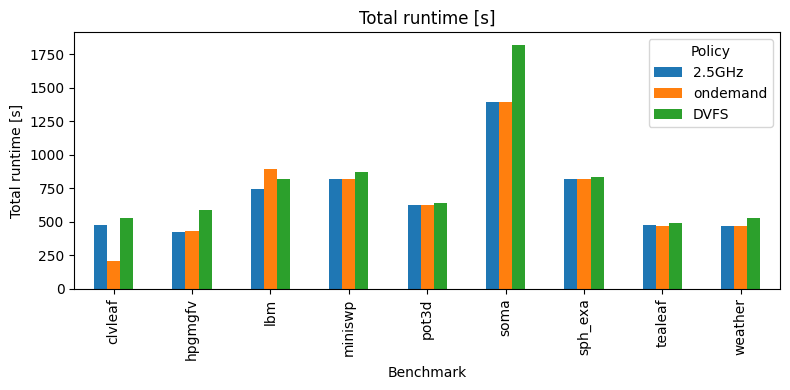

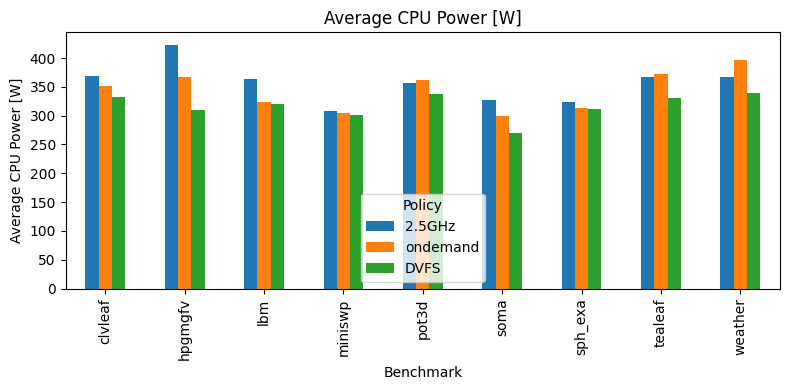

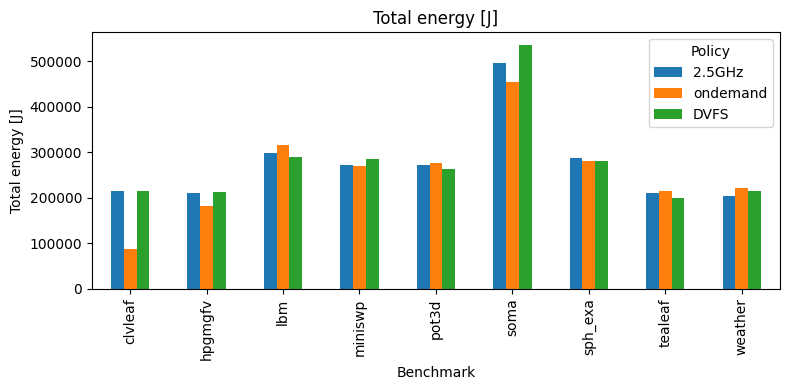

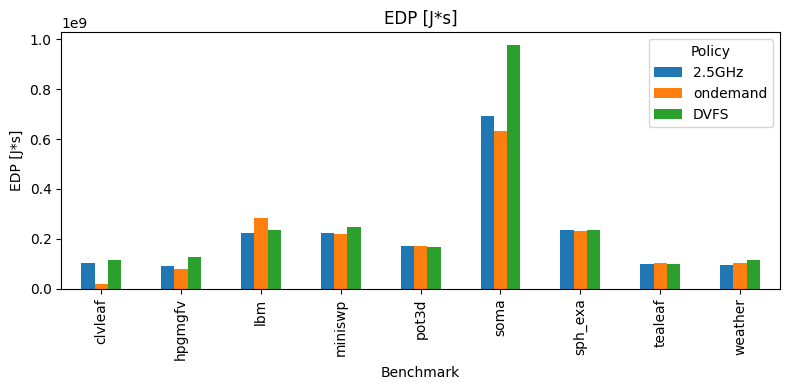

In [43]:
plot_benchmark_groups(summary_df, metrics_to_plot, policy_order)
